=== LAYOUT-AWARE RECEIPT VERIFICATION ===
📏 Image loaded: (1587, 1080, 3)

1. Detecting text regions...
   Found 32 individual text regions

2. Grouping text into lines...
   Grouped into 15 text lines

3. Extracting text from lines...

4. Verifying receipt structure...

🔍 ANALYZING LAYOUT STRUCTURE:
--------------------------------------------------
Line  0: unknown         -> 'wondr'
Line  1: transaction_status -> 'Transferberhasil'
Line  2: total_amount    -> 'Rp50.000'
Line  3: datetime        -> 'O4Nov2025-22:41:06WIB'
Line  4: transaction_id  -> 'RefID:20251104104059000887'
Line  5: receiver_title  -> 'Penerima'
Line  6: receiver_name   -> 'SdriIVAKRISTOVA'
Line  7: receiver_bank   -> 'BNI-0705/63133'
Line  8: unknown         -> 'Sumberdana'
Line  9: unknown         -> 'MUHAMMADNASIH'
Line 10: unknown         -> 'KKKKKKKQODA'
Line 11: unknown         -> 'Detailtransfer'
Line 12: total_amount    -> 'Nominal Rp50.000'
Line 13: fee_line        -> 'Biayatransaksi RpO'
Line 14: total_

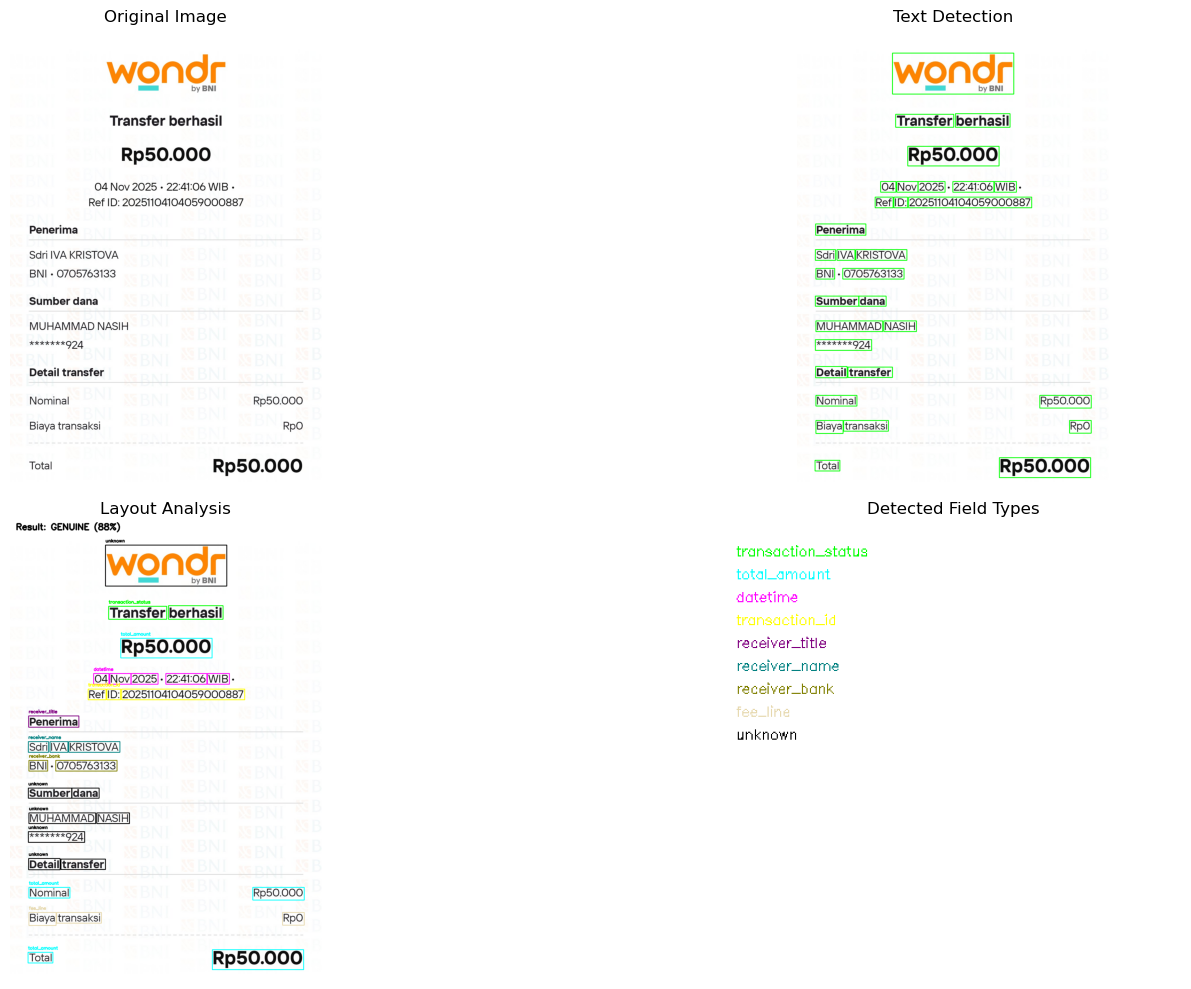


DETAILED LAYOUT ANALYSIS:
Line  0: unknown         -> 'wondr'
Line  1: transaction_status -> 'Transferberhasil'
Line  2: total_amount    -> 'Rp50.000'
Line  3: datetime        -> 'O4Nov2025-22:41:06WIB'
Line  4: transaction_id  -> 'RefID:20251104104059000887'
Line  5: receiver_title  -> 'Penerima'
Line  6: receiver_name   -> 'SdriIVAKRISTOVA'
Line  7: receiver_bank   -> 'BNI-0705/63133'
Line  8: unknown         -> 'Sumberdana'
Line  9: unknown         -> 'MUHAMMADNASIH'
Line 10: unknown         -> 'KKKKKKKQODA'
Line 11: unknown         -> 'Detailtransfer'
Line 12: total_amount    -> 'Nominal Rp50.000'
Line 13: fee_line        -> 'Biayatransaksi RpO'
Line 14: total_amount    -> 'Total Rp50.000'


In [ ]:
import cv2
import numpy as np
import pytesseract
import re
from matplotlib import pyplot as plt

def detect_text_regions(image):
    """Your existing function - this works well"""
    original = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    dilated = cv2.dilate(edges, kernel, iterations=2)
    
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    boxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        
        # Your existing filters - these are good!
        if w < 20 or h < 10:
            continue
        ratio = w / float(h)
        if ratio < 0.2 or ratio > 15:
            continue
        area = w * h
        if area < 50 or area > image.shape[0] * image.shape[1] * 0.5:
            continue
            
        boxes.append((x, y, w, h))
        cv2.rectangle(original, (x,y), (x+w, y+h), (0,255,0), 2)
    
    return original, boxes, gray, edges, dilated

def group_boxes_by_lines(boxes, line_threshold=15):
    """Group boxes that are on the same line"""
    if not boxes:
        return []
    
    # Sort by Y position
    boxes_sorted = sorted(boxes, key=lambda box: box[1])
    
    lines = []
    current_line = []
    current_y = boxes_sorted[0][1]
    
    for box in boxes_sorted:
        x, y, w, h = box
        
        # Check if this box is on the same line (within threshold)
        if abs(y - current_y) <= line_threshold:
            current_line.append(box)
        else:
            # New line detected
            if current_line:
                # Sort boxes in the line by X coordinate (left to right)
                current_line_sorted = sorted(current_line, key=lambda b: b[0])
                lines.append(current_line_sorted)
            current_line = [box]
            current_y = y
    
    # Don't forget the last line
    if current_line:
        current_line_sorted = sorted(current_line, key=lambda b: b[0])
        lines.append(current_line_sorted)
    
    return lines

def extract_text_from_line(image, line_boxes):
    """Extract combined text from boxes on the same line"""
    if not line_boxes:
        return ""
    
    # Get the combined region for the entire line
    x_coords = [box[0] for box in line_boxes]
    y_coords = [box[1] for box in line_boxes]
    widths = [box[2] for box in line_boxes]
    heights = [box[3] for box in line_boxes]
    
    x_min = min(x_coords)
    y_min = min(y_coords)
    x_max = max(x + w for x, w in zip(x_coords, widths))
    y_max = max(y + h for y, h in zip(y_coords, heights))
    
    # Extract the combined region
    roi = image[y_min:y_max, x_min:x_max]
    if roi.size == 0:
        return ""
    
    # Preprocess for better OCR
    roi = cv2.resize(roi, (roi.shape[1]*2, roi.shape[0]*2))
    _, roi_binary = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # OCR with optimized config
    custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz.:/- ·Rp '
    text = pytesseract.image_to_string(roi_binary, config=custom_config)
    
    return text.strip()

def parse_line_by_position(line_text, line_number):
    t = line_text.lower()

    # Strong keyword-based classification
    if any(k in t for k in ["transfer berhasil", "berhasil"]):
        return "transaction_status", line_text

    if re.search(r"rp\s*\d", t):
        return "total_amount", line_text

    if any(m in t for m in ["wib", "jan", "feb", "mar", "apr", "mei", "jun",
                            "jul", "agu", "sep", "okt", "nov", "des"]):
        return "datetime", line_text

    if "ref" in t and "id" in t:
        return "transaction_id", line_text

    if "penerima" in t:
        return "receiver_title", line_text

    # Name heuristics
    if any(prefix in t for prefix in ["sdri", "sdr", "bpk", "ibu"]):
        return "receiver_name", line_text

    if any(b in t for b in ["bni", "bca", "mandiri", "bri", "btn"]):
        return "receiver_bank", line_text

    if "sumber dana" in t:
        return "sender_title", line_text

    # Masked account
    if "***" in line_text or re.search(r"[xX]{4,}", t):
        return "sender_account", line_text

    # Detail transfer
    if "detail transfer" in t:
        return "detail_title", line_text

    # Nominal, Fee, Total lines
    if "nominal" in t:
        return "nominal_line", line_text
    if "biaya" in t:
        return "fee_line", line_text
    if t.startswith("total") or (" total " in t):
        return "total_line", line_text

    return "unknown", line_text


def extract_amount_from_text(text):
    """Extract amount value from text"""
    amount_match = re.search(r'Rp\s*([\d.,]+)', text.replace('.', ''))
    if amount_match:
        amount_str = amount_match.group(1).replace(',', '')
        return int(amount_str) if amount_str.isdigit() else None
    return None

def parse_detail_line(text):
    """Parse detail lines that have labels and amounts separated"""
    if "nominal" in text.lower():
        return "nominal", extract_amount_from_text(text)
    elif "biaya transaksi" in text.lower():
        return "fee", extract_amount_from_text(text)
    elif "total" in text.lower():
        return "total", extract_amount_from_text(text)
    return "unknown", None

def verify_receipt_authenticity(lines_data, expected_amount=None):
    """Verify receipt against the expected layout and content"""
    issues = []
    confidence = 100
    found_fields = []
    amounts = {}
    
    print("\n🔍 ANALYZING LAYOUT STRUCTURE:")
    print("-" * 50)
    
    # Check each line according to expected layout
    for i, line_data in enumerate(lines_data):
        field_type, text = line_data['field_type'], line_data['text']
        found_fields.append(field_type)
        
        print(f"Line {i:2d}: {field_type:15} -> '{text}'")
        
        # Verify fixed text fields
        if field_type == "receiver_title" and "penerima" not in text.lower():
            issues.append(f"Line {i}: Expected 'Penerima', got '{text}'")
            confidence -= 5
            
        elif field_type == "sender_title" and "sumber dana" not in text.lower():
            issues.append(f"Line {i}: Expected 'Sumber dana', got '{text}'")
            confidence -= 5
            
        elif field_type == "detail_title" and "detail transfer" not in text.lower():
            issues.append(f"Line {i}: Expected 'Detail transfer', got '{text}'")
            confidence -= 5
        
        # Extract and verify amounts
        if field_type in ["total_amount", "nominal_line", "fee_line", "total_line"]:
            amount = extract_amount_from_text(text)
            if amount:
                amounts[field_type] = amount
                
                # Parse detail lines further
                if field_type in ["nominal_line", "fee_line", "total_line"]:
                    detail_type, detail_amount = parse_detail_line(text)
                    if detail_amount:
                        amounts[detail_type] = detail_amount
    
    print("-" * 50)
    
    # Verify amount consistency
    print("\n💰 AMOUNT VERIFICATION:")
    all_amounts = [amt for amt in amounts.values() if amt is not None]
    
    if all_amounts:
        print(f"Found amounts: {amounts}")
        
        # Check if all amounts are consistent
        unique_amounts = set(all_amounts)
        if len(unique_amounts) > 1:
            issues.append(f"Amount mismatch: {unique_amounts}")
            confidence -= 20
        else:
            print("✓ All amounts are consistent")
            
        # Check against expected amount
        if expected_amount and expected_amount not in unique_amounts:
            issues.append(f"Expected amount {expected_amount} not found")
            confidence -= 30
        elif expected_amount:
            print(f"✓ Expected amount {expected_amount} verified")
    else:
        issues.append("No amounts found")
        confidence -= 30
    
    # Check required fields
    required_fields = [
        "transaction_status", "total_amount", "datetime", "transaction_id",
        "receiver_title", "receiver_name", "receiver_bank",
        "sender_title", "sender_name", "sender_account",
        "detail_title"
    ]
    
    missing_fields = [field for field in required_fields if field not in found_fields]
    if missing_fields:
        issues.append(f"Missing required fields: {missing_fields}")
        confidence -= len(missing_fields) * 3
    
    # Check transaction status
    status_lines = [line for line in lines_data if line['field_type'] == 'transaction_status']
    if status_lines and 'berhasil' not in status_lines[0]['text'].lower():
        issues.append("Transaction status not 'berhasil'")
        confidence -= 10
    elif status_lines:
        print("✓ Transaction status: BERHASIL")
    
    # Determine final result
    if confidence >= 80:
        result = "GENUINE"
    elif confidence >= 60:
        result = "SUSPECT"
    else:
        result = "FAKE"
    
    return {
        'result': result,
        'confidence': confidence,
        'issues': issues,
        'found_fields': found_fields,
        'amounts': amounts
    }

def layout_aware_receipt_verification(image_path, expected_amount=None):
    """Complete pipeline with layout awareness"""
    print("=== LAYOUT-AWARE RECEIPT VERIFICATION ===")
    
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not load image!")
        return
    
    print(f"📏 Image loaded: {image.shape}")
    
    # Step 1: Detect text regions
    print("\n1. Detecting text regions...")
    result_img, boxes, gray, edges, dilated = detect_text_regions(image)
    print(f"   Found {len(boxes)} individual text regions")
    
    # Step 2: Group boxes by lines
    print("\n2. Grouping text into lines...")
    lines = group_boxes_by_lines(boxes, line_threshold=15)
    print(f"   Grouped into {len(lines)} text lines")
    
    # Step 3: Extract text from each line
    print("\n3. Extracting text from lines...")
    lines_data = []
    
    for i, line_boxes in enumerate(lines):
        text = extract_text_from_line(gray, line_boxes)
        if text and text.strip():
            field_type, parsed_text = parse_line_by_position(text, i)
            lines_data.append({
                'line_number': i,
                'text': text.strip(),
                'field_type': field_type,
                'boxes': line_boxes
            })
    
    # Step 4: Verify authenticity
    print("\n4. Verifying receipt structure...")
    verification = verify_receipt_authenticity(lines_data, expected_amount)
    
    # Step 5: Display results
    print(f"\n🎯 VERIFICATION RESULT: {verification['result']}")
    print(f"📊 Confidence: {verification['confidence']}%")
    print(f"📋 Fields found: {len(verification['found_fields'])}")
    
    if verification['issues']:
        print("\n❌ Issues detected:")
        for issue in verification['issues']:
            print(f"   - {issue}")
    else:
        print("\n✅ No issues detected")
    
    # Step 6: Create visualization
    annotated_img = image.copy()
    
    # Color coding for different field types
    colors = {
        'app_logo': (255, 0, 0),          # Red
        'bank_name': (0, 0, 255),         # Blue
        'transaction_status': (0, 255, 0), # Green
        'total_amount': (255, 255, 0),    # Cyan
        'datetime': (255, 0, 255),        # Magenta
        'transaction_id': (0, 255, 255),  # Yellow
        'receiver_title': (128, 0, 128),  # Purple
        'receiver_name': (128, 128, 0),   # Olive
        'receiver_bank': (0, 128, 128),   # Teal
        'sender_title': (128, 128, 128),  # Gray
        'sender_name': (64, 64, 64),      # Dark Gray
        'sender_account': (192, 192, 192), # Light Gray
        'detail_title': (255, 165, 0),    # Orange
        'nominal_line': (255, 192, 203),  # Pink
        'fee_line': (173, 216, 230),      # Light Blue
        'total_line': (144, 238, 144),    # Light Green
        'unknown': (0, 0, 0)              # Black
    }
    
    # Draw annotated boxes
    for line_data in lines_data:
        color = colors.get(line_data['field_type'], (0, 0, 0))
        
        for box in line_data['boxes']:
            x, y, w, h = box
            cv2.rectangle(annotated_img, (x, y), (x+w, y+h), color, 2)
        
        # Add field type label using first box in line
        if line_data['boxes']:
            x, y, w, h = line_data['boxes'][0]
            label = f"{line_data['field_type']}"
            cv2.putText(annotated_img, label, (x, y-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    # Add final result to image
    result_text = f"Result: {verification['result']} ({verification['confidence']}%)"
    cv2.putText(annotated_img, result_text, (20, 30), 
               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3)
    
    # Display results
    plt.figure(figsize=(20, 10))
    
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title("Text Detection")
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    plt.title("Layout Analysis")
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    # Create legend
    legend_img = np.ones((400, 400, 3), dtype=np.uint8) * 255
    y_offset = 30
    for field_type, color in colors.items():
        if any(field_type in line['field_type'] for line in lines_data):
            cv2.putText(legend_img, field_type, (10, y_offset), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
            y_offset += 20
    
    plt.imshow(cv2.cvtColor(legend_img, cv2.COLOR_BGR2RGB))
    plt.title("Detected Field Types")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return verification, lines_data

# Test with your image
def test_with_your_image():
    """Test with your actual receipt image"""
    image_path = "../input/new/template_02.jpg"
    expected_amount = 50000
    
    result, lines_data = layout_aware_receipt_verification(image_path, expected_amount)
    
    print("\n" + "="*60)
    print("DETAILED LAYOUT ANALYSIS:")
    print("="*60)
    for line in lines_data:
        print(f"Line {line['line_number']:2d}: {line['field_type']:15} -> '{line['text']}'")

# Execute
test_with_your_image()